### Imports and defining some functions 

In [1]:
%pylab inline
#%load_ext line_profiler
import exoplanet as xo
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
sns.set_context('paper',font_scale=0.8)
sns.set_style('ticks')
rcParams['figure.dpi'] = 160
def _tfold(t, per, tc):
    return np.mod(((t - tc) + 0.5 * per),per) -  0.5 * per

texp_lc = 0.02
texp_sc = texp_lc/30

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.dpi'] = 160 # execute twice

## Generate Long and Short Cadence Light Curve

In [6]:
np.random.seed(42)
per = 11.512312 * 10
b=0.9
r=0.0244

truth = dict(per=per, tc=5.124124,b=b, r=r, ecc=0.0, omega=90)
u = np.array([0.4451, 0.2297])

yerr_lc = 2e-4 / 1.48
yerr_sc = yerr_lc*sqrt(texp_lc/texp_sc)

t_sc = np.arange(0, 1400, texp_sc)
orbit0 = xo.orbits.KeplerianOrbit(
    period=truth['per'], 
    t0=truth['tc'], 
    b=truth['b'], 
    ecc=truth['ecc'],
    omega=truth['omega'],
    rho_star = 1 # grams per / cc
)

#
model_sc = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit0, r=truth['r'], t=t_sc,texp=0.02/30).eval()
model_sc = model_sc.flatten()
data_sc = (model_sc + yerr_sc * np.random.randn(*model_sc.shape)).reshape(-1) # need this for single planet fit
tfold_sc = _tfold(t_sc, truth['per'],truth['tc'])
data_lc = data_sc.reshape(-1,30).mean(axis=1)
model_lc = model_sc.reshape(-1,30).mean(axis=1)
t_lc = t_sc.reshape(-1,30).mean(axis=1)

bcut = abs(tfold_sc) < 0.2
t_sc = t_sc[bcut]
model_sc = model_sc[bcut]
data_sc = data_sc[bcut]
tfold_sc = tfold_sc[bcut]
isort_sc = argsort(tfold_sc)

tfold_lc = _tfold(t_lc, truth['per'],truth['tc'])
bcut = abs(tfold_lc) < 0.2
t_lc = t_lc[bcut]
model_lc = model_lc[bcut]
data_lc = data_lc[bcut]
tfold_lc = tfold_lc[bcut]
isort_lc = argsort(tfold_lc)


optimizing logp for variables: [r]
14it [00:00, 27.42it/s, logp=1.793861e+03] 
message: Optimization terminated successfully.
logp: -44414.86476385265 -> 1793.8610159270747
optimizing logp for variables: [logrho, r]
17it [00:00, 37.46it/s, logp=2.074063e+03] 
message: Optimization terminated successfully.
logp: 1793.8610159270747 -> 2074.0632284961875


{'r_interval__': array(-1.38455703), 'logrho_interval__': array(0.21357041), 'r': array(0.02002781), 'logrho': array(1.06381155), 'rho': array(11.58274659), 'light_curve': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.92112778e-05, -3.75407695e-04, -4.43920361e-04,
       -4.75552911e-04, -4.89866503e-04, -4.92286471e-04, -4.83605007e-04,
       -4.60823912e-04, -4.13364036e-04, -2.43647508e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -4.32622401e-05, -3.56768353e-04, -4.36595194e-04,
       -4.71992324e-04, -4.88485940e-04, -4.92619516e-04, -4.85758236e-04,
       -4.65582756e-04, -4.23354917e-04, -3.03046075e-04, -2.19964013e-07,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
   

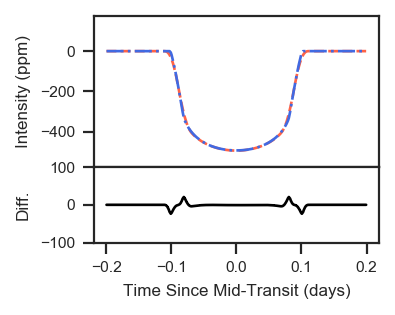

In [11]:
# Plot long cadence light curve

with pm.Model() as xo_model_lc:
    mean = 0
    r = pm.Uniform("r", lower=0.00, upper=0.1, testval=0.05)
    b = 0 
    logrho = pm.Uniform("logrho", lower=-10, upper=10, testval=0)
    rho = pm.Deterministic("rho", 10**logrho)
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_lc, texp=0.02, oversample=100,order=2) 
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curve", light_curve)
    pm.Normal("obs", mu=light_curve, sd=yerr_lc, observed=model_lc)
    map_soln = xo.optimize(start=xo_model_lc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)

print(map_soln)

def plotter(t, y1, y2):
    fig = figure(figsize=(2.5,2))
    gs = GridSpec(3, 1, figure=fig)
    ax1 = fig.add_subplot(gs[0:-1])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax2 = fig.add_subplot(gs[-1],sharex=ax1)

    sca(ax1)
    plt.plot(t, y1, color="C1",ls='--',)
    ylabel('Intensity (ppm)')
    plot(t,y2, color="C2",ls='-.',)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ylim(-575,175)
    sca(ax2)
    difference = y1 - y2

    plot(t,difference, label="long cadence b =0 ",marker=',')
    ylabel('Diff.')
    xlabel('Time Since Mid-Transit (days)')
    tight_layout()


t = tfold_lc[isort_lc]
y1 =  model_lc[isort_lc] * 1e6
y2 = map_soln["light_curve"][isort_lc] * 1e6
plotter(t, y1, y2)
ylim(-100,100)
fig = gcf()
fig.subplots_adjust(hspace=0)
gcf().savefig('../paper/fig_diagram-lc_per=115.pdf')


optimizing logp for variables: [r]
0it [00:00, ?it/s]/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
8it [00:00, 486.77it/s, logp=4.860583e+04]/Users/petigura/anaconda2/envs/py37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
9it [00:00, 18.35it/s, logp=4.860583e+04] 
message: Optimization terminated succe

{'r_interval__': array(-1.38699785), 'logrho_interval__': array(0.21347912), 'r': array(0.01998875), 'logrho': array(1.06336027), 'rho': array(11.57071688), 'light_curve': array([0., 0., 0., ..., 0., 0., 0.])}


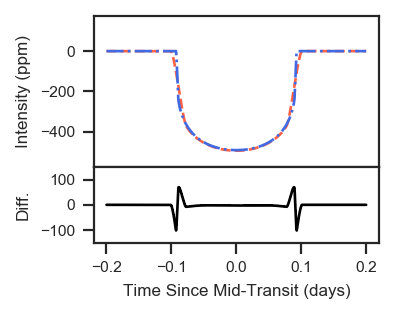

In [8]:
with pm.Model() as xo_model_sc:
    mean = 0
    r = pm.Uniform("r", lower=0.00, upper=0.1, testval=0.02)
    b = 0 
    logrho = pm.Uniform("logrho", lower=-10, upper=10, testval=3)
    rho = pm.Deterministic("rho", 10**logrho)
    orbit = xo.orbits.KeplerianOrbit(period=truth['per'], t0=truth['tc'], b=b, rho_star=rho)
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t_sc, texp=None)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curve", light_curve)
    pm.Normal("obs", mu=light_curve, sd=yerr_sc, observed=model_sc)
    map_soln = xo.optimize(start=xo_model_sc.test_point,vars=[r])
    map_soln = xo.optimize(start=map_soln)

print(map_soln)

t = tfold_sc[isort_sc]
y1 =  model_sc[isort_sc] * 1e6
y2 = map_soln["light_curve"][isort_sc] * 1e6
plotter(t, y1, y2)
ylim(-150,150)
fig = gcf()
fig.subplots_adjust(hspace=0)
gcf().savefig('../paper/fig_diagram-sc_per=115.pdf')


In [ ]:
plot(t_sc,model_sc,',')
xlim(0,10)